### 1) 패키지 참조

In [1]:
import sys
sys.path.append('../../')
import helper

import numpy as np
import seaborn as sb
from pandas import read_excel, DataFrame, get_dummies, CategoricalDtype, merge
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler

from tensorflow.keras.models import Sequential # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense      # 모델 객체에 학습층을 쌓기 위한 클래스
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 2) 데이터셋 준비

- `1년 내 재발 여부` (제외), `재발 여부`만 확인
- `수술날짜`와 `재발날짜` (제외) b/c 재발하지 않은 환자의 경우는 마지막 검사 날짜이므로 의미가 있는 형태가 아닌 것 같으므로

|필드명|설명|비고|
|--|--|--|
|id|고유번호||
|age|나이||
|sex|성별|0 = 여성, 1 = 남성|
|weight|체중||
|OP_date|수술 날짜||
|Recur|재발 여부|0 = 마지막 관찰시점까지 재발 안함, 1 = 재발|
|Recur_1y|1년 내 재발 여부|0 = 1년 내 재발 안함, 1 = 1년 내 재발|
|Recur_date|재발 날짜|재발하지 않은 환자의 경우 마지막 검사 날짜|
|SBP|수축기 혈압||
|CA19.9|종양표지자의 일종인 CA19-9값||
|CRP|C-반응 단백질 수치||
|CEA|종용표지자의 일종인 CEA 값||
|post.CEA|수술 직후 CEA 값||
|stage|암의 병기|1=1기, 2=2기, 3=3기; 서열 척도 아님!|
|smoking|흡연 여부|0 = 비흡연, 1 = 흡연|
|obesity|비만 여부|0 = 정상, 1 = 비만|
|post.CA19.9|수술 직후 CA19-9값||
|post.CA19.9.binary|0 = (post CA19.9 =< 37), 1 = (37 < post CA19.9)||
|post.CA19.9.3grp|1= (post CA19.9 =< 37), 2=(37 < post CA19.9 <= 100), 3=(70 < post CA19.9)||




In [3]:
origin = read_excel('https://data.hossam.kr/F03/biostat.xlsx', index_col='id')
origin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   age                 156 non-null    int64         
 1   sex                 156 non-null    int64         
 2   weight              156 non-null    float64       
 3   OP_date             156 non-null    datetime64[ns]
 4   Recur               156 non-null    int64         
 5   Recur_1y            156 non-null    int64         
 6   Recur_date          156 non-null    datetime64[ns]
 7   SBP                 156 non-null    float64       
 8   CA19.9              156 non-null    float64       
 9   CRP                 156 non-null    float64       
 10  CEA                 156 non-null    float64       
 11  post.CEA            156 non-null    float64       
 12  stage               156 non-null    int64         
 13  smoking             156 non-null    int64         
 14 

### 3) 데이터 전처리
- 결측치 확인

In [4]:
origin.isna().sum()

age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

- 불필요한 필드 제거

In [5]:
data_pre1 = origin.drop(['Recur_1y', 'OP_date', 'Recur_date'], axis=1)
data_pre1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   SBP                 156 non-null    float64
 5   CA19.9              156 non-null    float64
 6   CRP                 156 non-null    float64
 7   CEA                 156 non-null    float64
 8   post.CEA            156 non-null    float64
 9   stage               156 non-null    int64  
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  post.CA19.9.3grp    156 non-null    int64  
dtypes: float64(7), int64(8)
memory usage: 19.5 KB


- 타입 확인 및 변환

In [6]:
data_pre1.dtypes

age                     int64
sex                     int64
weight                float64
Recur                   int64
SBP                   float64
CA19.9                float64
CRP                   float64
CEA                   float64
post.CEA              float64
stage                   int64
smoking                 int64
obesity                 int64
post.CA19.9           float64
post.CA19.9.binary      int64
post.CA19.9.3grp        int64
dtype: object

In [7]:
data_pre2 = data_pre1.copy()
data_pre2
# 순서 없는 범주 설정
ctype = ['sex', 'Recur', 'stage', 'smoking', 'obesity']
for a in ctype:
    data_pre2[a] = data_pre2[a].astype('category')
data_pre2.dtypes

# 순서 있는 범주 설정
n_ctype = ['post.CA19.9.binary', 'post.CA19.9.3grp']
n_cat_dict = {}
for a in n_ctype:
    df = DataFrame(data_pre2[a].value_counts().sort_index())
    n_cat_dict[a] = list(df.index)
    print('n_cat_dict[%s]: ' % a, n_cat_dict[a])

    cat_type = CategoricalDtype(categories=n_cat_dict[a], ordered = True)
    data_pre2[a] = data_pre2[a].astype(cat_type)
data_pre2.dtypes


n_cat_dict[post.CA19.9.binary]:  [0, 1]
n_cat_dict[post.CA19.9.3grp]:  [1, 2, 3]


age                      int64
sex                   category
weight                 float64
Recur                 category
SBP                    float64
CA19.9                 float64
CRP                    float64
CEA                    float64
post.CEA               float64
stage                 category
smoking               category
obesity               category
post.CA19.9            float64
post.CA19.9.binary    category
post.CA19.9.3grp      category
dtype: object

- 필드명 중 '.'을 '_'로 변환
    - 이유: 이름 중간에 '.'가 있으면 필드명 인식을 못함
    - 해결방법: 역다음표(``)로 둘러주면 인식 가능

In [8]:
# data_pre3 = data_pre2.copy()
# data_pre3
# for a in data_pre3.columns:
#     if '.' in a:
#         new = a.replace('.', '_')
#         data_pre3.rename(columns = {a:new}, inplace = True)
#     else:
#         continue
# data_pre3

### 4) 탐색적 데이터 분석
- 기본 통계 확인, 박스플롯 확인

In [9]:
data_pre2.describe()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,56.858974,68.125624,115.898871,1158.631410,3.062821,3.930128,5.363462,48.193259
std,12.790343,14.467480,37.701583,6709.440806,3.550361,4.135752,12.846207,22.921452
min,25.000000,40.000000,5.629379,1.000000,0.100000,0.300000,0.100000,30.760115
25%,50.000000,58.257205,89.074804,10.400000,0.100000,1.500000,0.600000,34.908674
50%,58.000000,69.084391,114.647853,23.150000,1.300000,2.400000,1.650000,41.285774
75%,65.000000,80.053547,144.331917,61.725000,4.850000,4.525000,4.800000,51.216016
max,82.000000,95.000000,206.847716,48599.800000,12.300000,20.400000,118.500000,174.433426


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

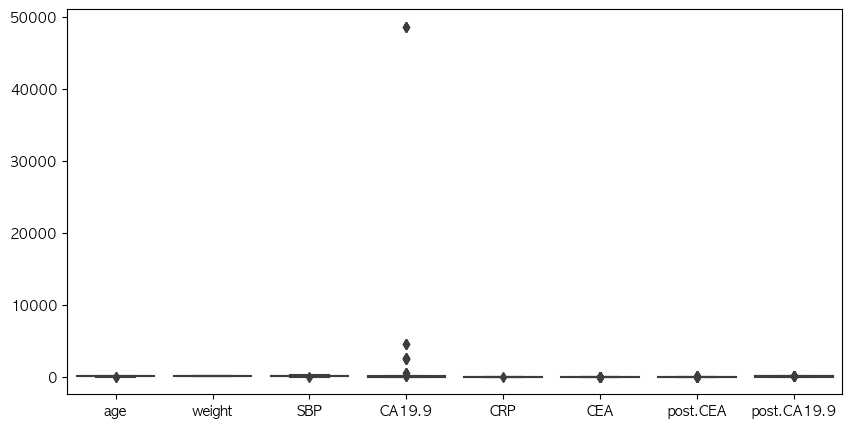

In [10]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (10, 5))
sb.boxplot(data = data_pre2)
plt.show()
plt.close()

> "CA19.9"에서 약 50000정도의 값이 발견되었음. 이 값을 이상치인지 확인
>
> 전문분야에서는 전문지식이 필요함
>
> 확인 결과 50000정도의 수치인 경우 시한부일 가능성 높음

- 이상치 확인

In [11]:
data_pre2.query("`CA19.9` > 40000")

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
63,60,1,80.024716,1,192.226734,48599.8,9.7,4.7,9.5,2,0,1,41.421145,1,2
115,61,1,74.031541,1,176.594650,48599.3,10.4,6.6,6.6,2,0,1,36.516956,0,1


> 수치가 4만이 넘는 경우가 모두 췌장암 2기로 확인됨(stage==2)
>
> 췌장암 2기 데이터 확인

In [12]:
data_pre2.query("stage == 2")

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,
9,69,0,53.920287,1,108.237287,19.9,0.1,4.6,15.1,2,1,0,62.095475,1,2
10,39,1,64.035273,0,88.061020,84.2,9.6,4.3,6.1,2,1,0,50.118498,1,2
11,64,1,87.019677,1,93.901218,48599.6,9.4,1.4,3.9,2,1,1,34.956666,0,1
12,69,1,70.208801,1,163.587691,49.5,0.1,7.2,8.2,2,1,1,34.626853,0,1
23,64,1,82.150157,0,169.410154,67.3,3.5,1.8,0.9,2,1,0,34.890297,0,1
26,59,0,60.346471,0,121.918068,12.7,1.7,1.2,0.2,2,1,0,44.344380,1,2
27,41,0,53.729653,0,95.660858,7.6,0.1,8.3,19.4,2,1,1,34.043468,0,1
29,48,1,70.060164,0,108.765715,15.0,3.8,6.8,3.6,2,0,0,44.855612,1,2
30,34,1,71.468074,0,51.737041,49.6,3.9,4.2,1.5,2,0,0,43.407932,1,2


> 다른 췌장암 2기와 비교했을 경우 큰 차이가 나므로 `CA19.9` 수치가 4만을 넘는 경우를 `이상치로 판단`하고 제거

- 이상치 정제

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

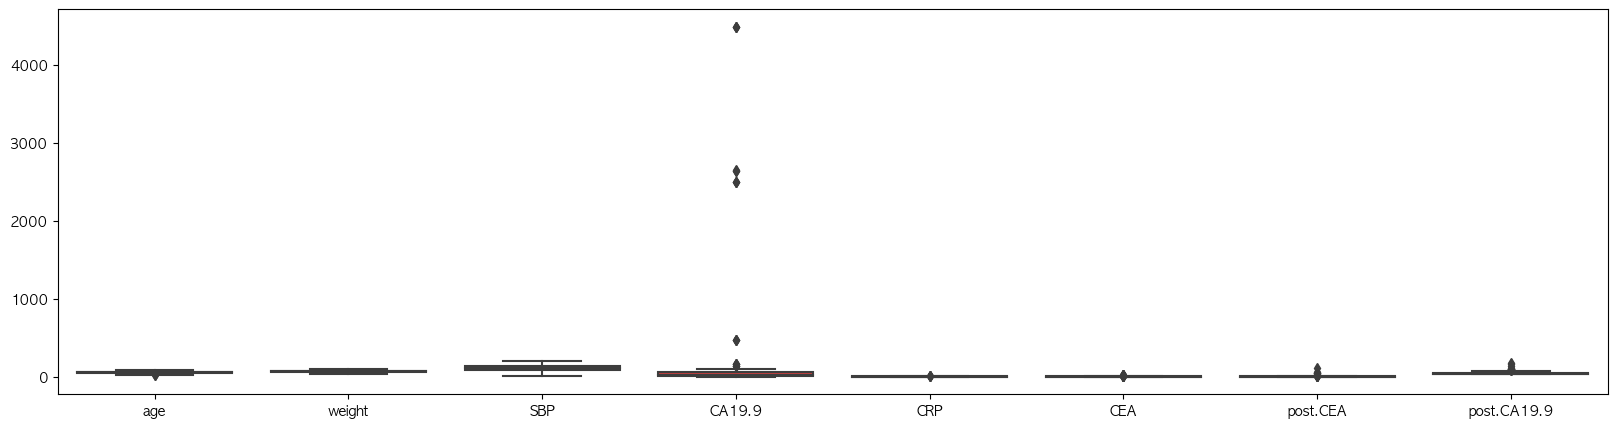

In [13]:
data_pre3 = data_pre2.drop(data_pre2.query("`CA19.9` > 40000").index)
data_pre3

plt.figure(figsize = (20, 5))
sb.boxplot(data = data_pre3)
plt.show()
plt.close()

> 데이터의 분포가 상이하고 이상치가 있으므로 RobustScaler로 표준화 실행

- 산점도 행렬 그래프와 추세선 확인
    - 로지스틱 회귀이므로 산점도와 추세선을 볼 필요가 없어 보이지만, 그래도 확인

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

<Figure size 3000x3000 with 0 Axes>

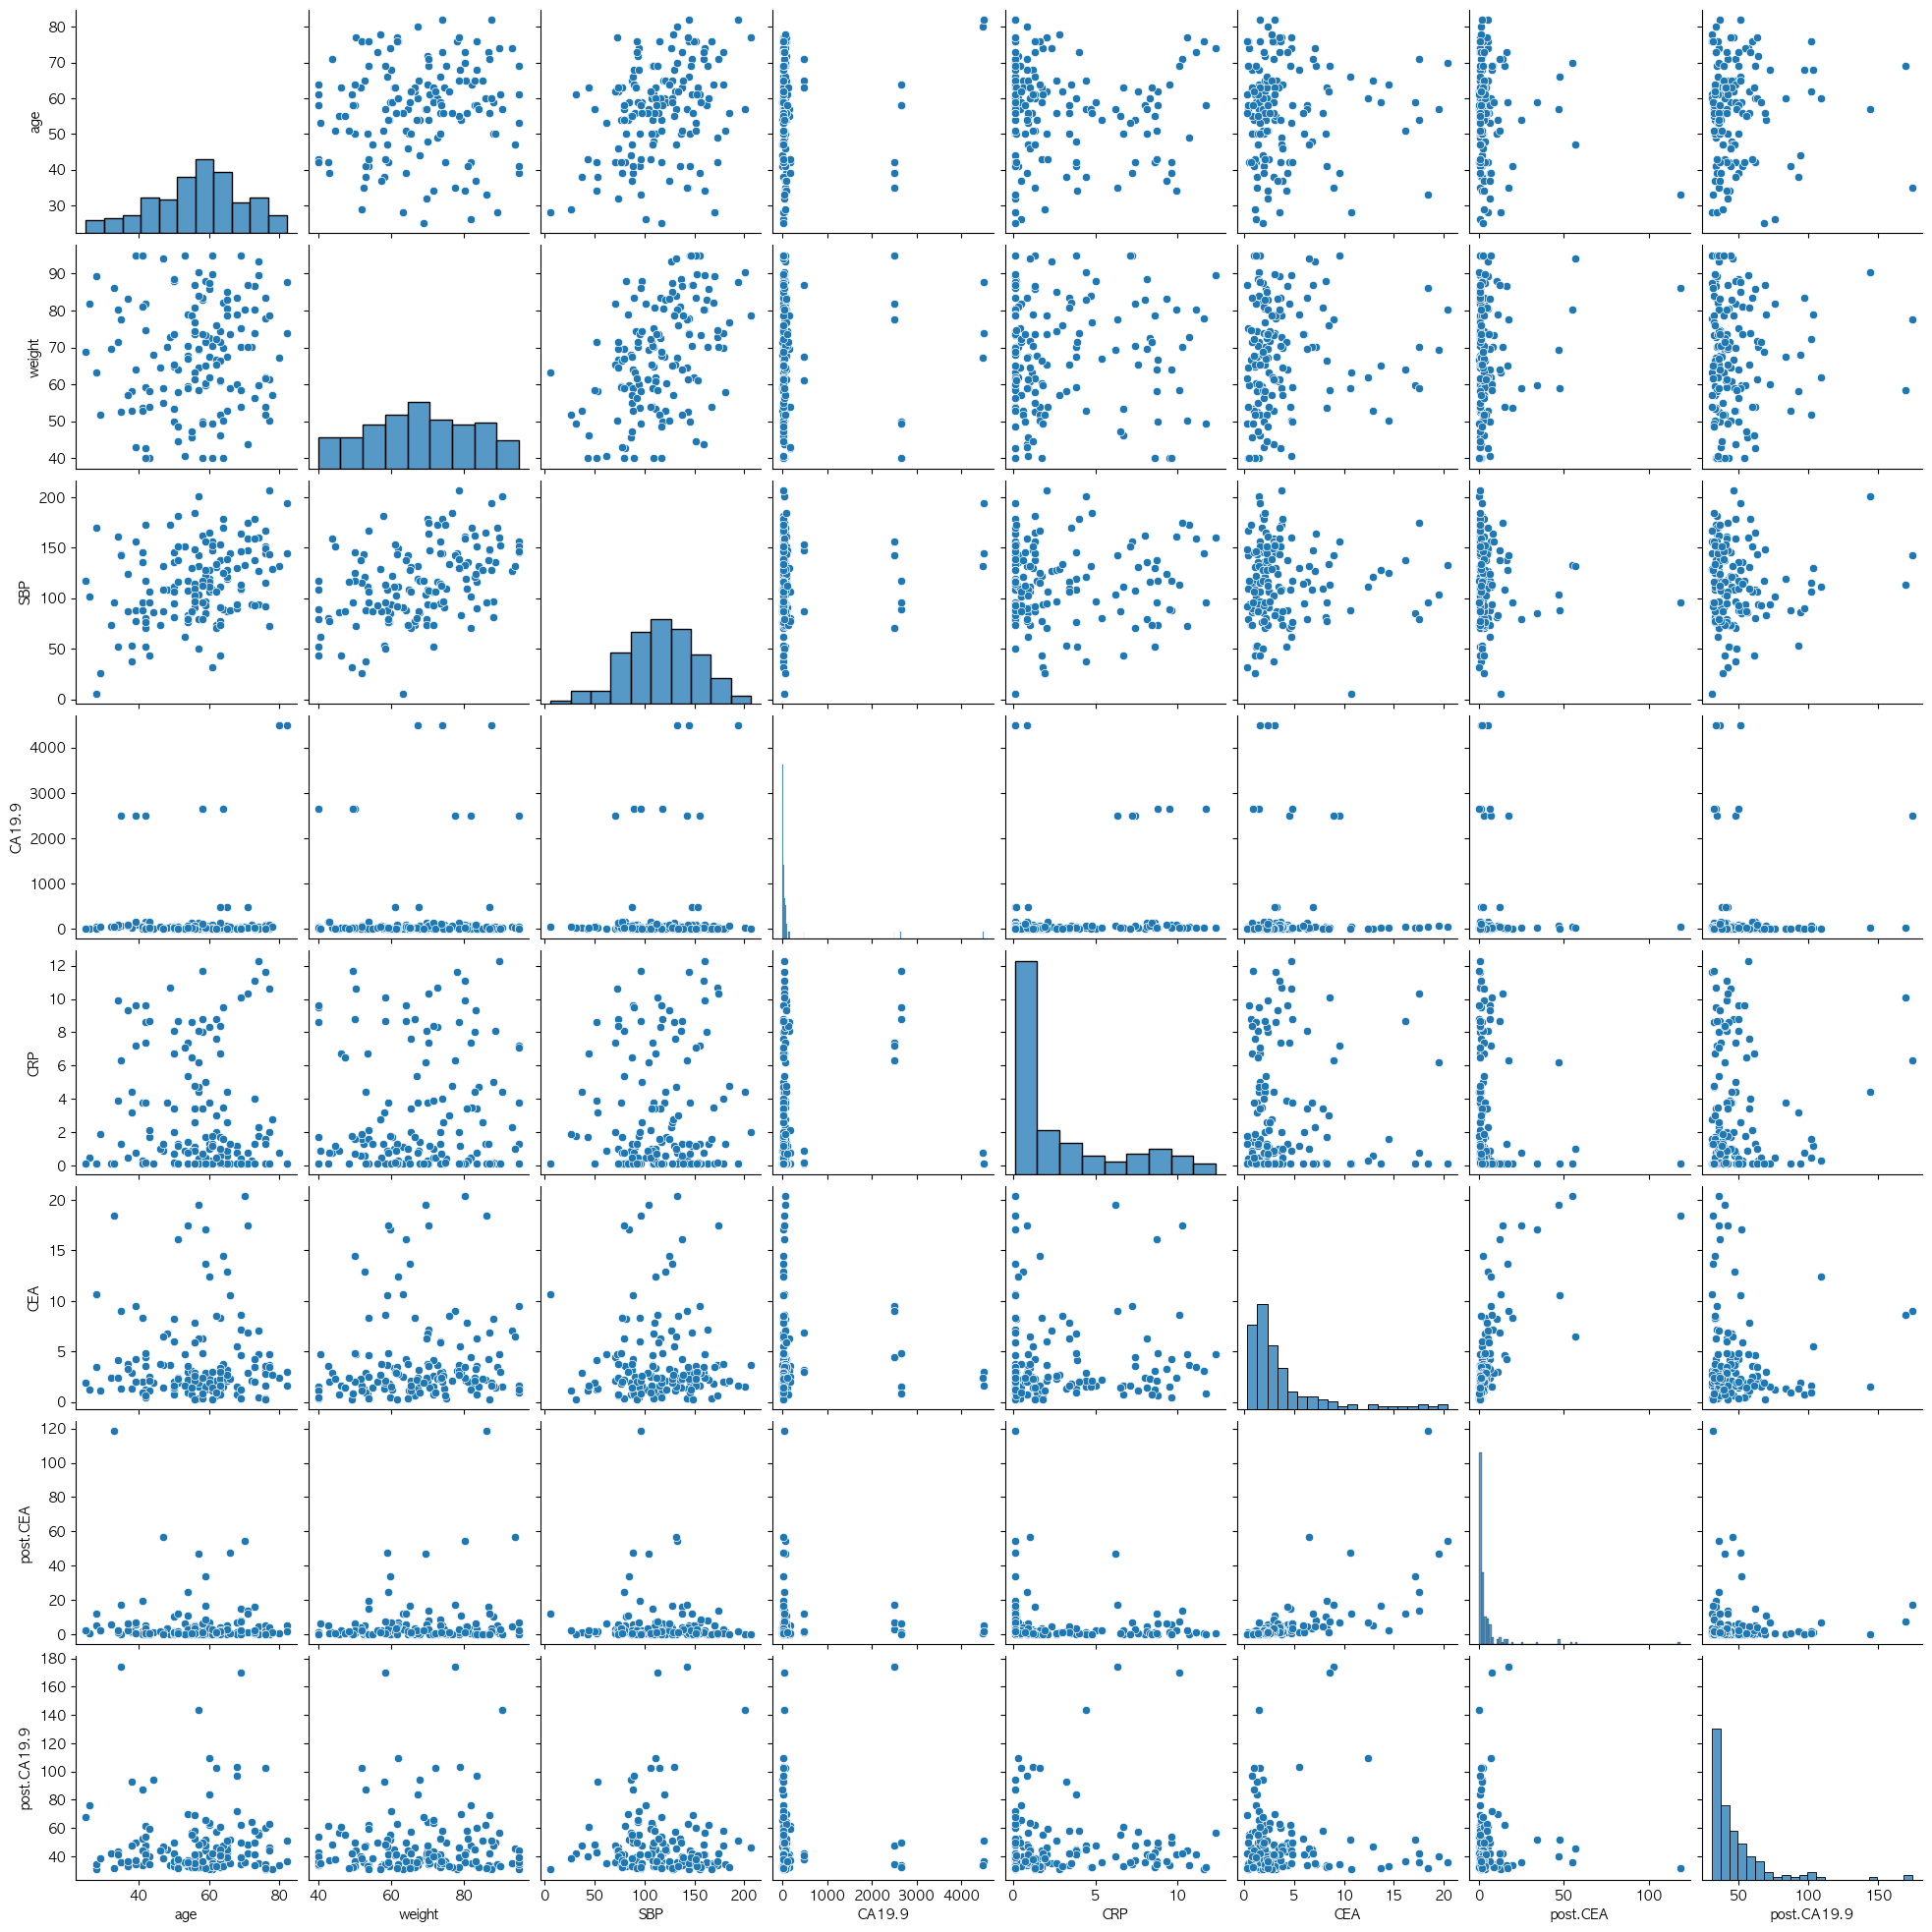

In [14]:
plt.figure(figsize = (30, 30))
sb.pairplot(data_pre3)
plt.show()
plt.close()

### 5) 데이터셋 분할
- 랜덤시드 고정

In [15]:
np.random.seed(777)

- 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [16]:
x = data_pre3.drop(['Recur'], axis=1)
x.head()
y = data_pre3[['Recur']]
y.head()

,Recur
id,
1,1
2,0
3,0
4,1
5,1


- 데이터 표준화
    - 명목형 변수는` 더미변수로 변환`해야 하므로 데이터를 `종류별로 구분`
    - 연속형 변수(x_n)/명목형 변수(x_c) 추출

In [17]:
x_n = x.drop(['sex', 
             'stage', 
             'smoking', 
             'obesity', 
             'post.CA19.9.binary', 
             'post.CA19.9.3grp'],
             axis = 1)
x_n.head()
x_n.info()

x_c = x.filter(['sex', 
                'stage', 
                'smoking', 
                'obesity', 
                'post.CA19.9.binary', 
                'post.CA19.9.3grp'])
x_c.head()           
x_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          153 non-null    int64  
 1   weight       153 non-null    float64
 2   SBP          153 non-null    float64
 3   CA19.9       153 non-null    float64
 4   CRP          153 non-null    float64
 5   CEA          153 non-null    float64
 6   post.CEA     153 non-null    float64
 7   post.CA19.9  153 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 10.8 KB
<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 156
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   sex                 153 non-null    category
 1   stage               153 non-null    category
 2   smoking             153 non-null    category
 3   obesity             153 non-null    category
 4   post.CA19.9.binary  153 no

- 데이터 표준화 
    - 연속형 변수(x_n) 표준화
    - 극단치(CA19.9)가 있으므로 RobustScaler()로 표준화 실행

In [18]:
x_scaler = RobustScaler()
x_scale = x_scaler.fit_transform(x_n)
x_scale_df = DataFrame(x_scale, index=x_n.index, columns=x_n.columns)
x_scale_df.head()

,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9
id,,,,,,,,
1,1.600000,0.290932,0.544846,93.271399,-0.279070,0.214286,0.897436,-0.270923
2,-0.533333,-0.148740,-0.095480,0.290188,-0.279070,-0.464286,-0.025641,-0.511167
3,-2.000000,-0.226134,-1.942439,0.290188,-0.279070,2.964286,2.769231,-0.608452
4,-1.533333,-0.739154,0.538467,0.878914,0.000000,-0.392857,-0.307692,-0.310335
5,-0.600000,0.232069,1.053689,0.321503,2.186047,0.464286,-0.307692,-0.442220


- 명목형 변수를 더미변수로 변환
    - 데이터의 종류가 몇가지인지 확인

In [19]:
for a in x_c.columns:
    print(x_c[a].value_counts())

sex
1    99
0    54
Name: count, dtype: int64
stage
3    78
2    39
1    36
Name: count, dtype: int64
smoking
0    113
1     40
Name: count, dtype: int64
obesity
0    96
1    57
Name: count, dtype: int64
post.CA19.9.binary
1    94
0    59
Name: count, dtype: int64
post.CA19.9.3grp
2    80
1    59
3    14
Name: count, dtype: int64


> 데이터 엑셀파일에서 `stage`, `post.CA19.9.3grp` 필드만 값이 3종류로 확인됨

In [20]:
x_c_dm = get_dummies(x_c,
                     columns = ['stage', 'post.CA19.9.3grp'],
                     drop_first = True,
                     dtype = 'int') # 'int'로 안 주면 'bool'이 default
x_c_dm.head()

,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,
1,1,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0
3,1,1,0,0,0,1,0,0
4,1,1,1,0,0,1,0,0
5,1,1,0,0,0,1,0,0


- 연속형과 더미변수로 변환된 명목형을 결합

In [21]:
x_df = merge(x_scale_df, x_c_dm, left_index=True, right_index=True)
print(x_df.shape)
x_df.head()

(153, 16)


,age,weight,SBP,CA19.9,CRP,CEA,post.CEA,post.CA19.9,sex,smoking,obesity,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,
1,1.600000,0.290932,0.544846,93.271399,-0.279070,0.214286,0.897436,-0.270923,1,1,1,0,0,1,0,0
2,-0.533333,-0.148740,-0.095480,0.290188,-0.279070,-0.464286,-0.025641,-0.511167,0,1,0,0,0,1,0,0
3,-2.000000,-0.226134,-1.942439,0.290188,-0.279070,2.964286,2.769231,-0.608452,1,1,0,0,0,1,0,0
4,-1.533333,-0.739154,0.538467,0.878914,0.000000,-0.392857,-0.307692,-0.310335,1,1,1,0,0,1,0,0
5,-0.600000,0.232069,1.053689,0.321503,2.186047,0.464286,-0.307692,-0.442220,1,1,0,0,0,1,0,0


- 훈련 데이터와 검증 데이터 분할

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_df,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((107, 16), (46, 16), (107, 1), (46, 1))

In [23]:
len(x_train.iloc[0])

16

### 6) 모델 개발
- 모델 정의
    - 데이터가 `단순하고 개수가 적다`면 `과(대)적합이 발생할 확률이 높고`, 또한 `Dense 층을 많이 쌓을수록` `과적합이 발생할 확률이 높`기 때문에 또한 주의하면서 적절한 크기와 모델층을 쌓아야 한다

In [24]:
my_model = Sequential()

my_model.add(Dense(32, activation='relu', input_shape=(len(x_train.iloc[0]),)))
my_model.add(Dense(1, activation = 'sigmoid'))
my_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 577 (2.25 KB)
Trainable params: 577 (2.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- 학습하기

In [25]:
result = my_model.fit(x_train,
                      y_train,
                      epochs=500,
                      validation_data = (x_test, y_test),
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience=10,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.001,
                                                   verbose=1
                                                   )])

Epoch 1/500
4/4 [==============================] - 1s 54ms/step - loss: 2.0386 - acc: 0.3645 - val_loss: 1.2755 - val_acc: 0.3913 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 1.7962 - acc: 0.3271 - val_loss: 1.2002 - val_acc: 0.4130 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 10ms/step - loss: 1.6298 - acc: 0.3364 - val_loss: 1.1327 - val_acc: 0.4130 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 10ms/step - loss: 1.4861 - acc: 0.3645 - val_loss: 1.0679 - val_acc: 0.3913 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 1.3478 - acc: 0.3645 - val_loss: 1.0150 - val_acc: 0.4348 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 9ms/step - loss: 1.2453 - acc: 0.3738 - val_loss: 0.9649 - val_acc: 0.4348 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 9ms/step - loss: 1.1165 - acc: 0.3925 - val_loss: 0.9013 - val_acc: 0.4130 - lr: 0.0010
Epo

### 7) 학습 결과 평가
- 학습결과 확인

In [26]:
result_df = DataFrame(result.history)
result_df['epochs']=result_df.index+1
result_df.set_index(keys='epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,2.038604,0.364486,1.275539,0.391304,0.001
2,1.796206,0.327103,1.200166,0.413043,0.001
3,1.629816,0.336449,1.132728,0.413043,0.001
4,1.486078,0.364486,1.067948,0.391304,0.001
5,1.347823,0.364486,1.015018,0.434783,0.001
...,...,...,...,...,...
113,0.201088,0.953271,0.578067,0.782609,0.001
114,0.199861,0.953271,0.579947,0.782609,0.001
115,0.197559,0.953271,0.584852,0.782609,0.001


- 학습 결과 시각화

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

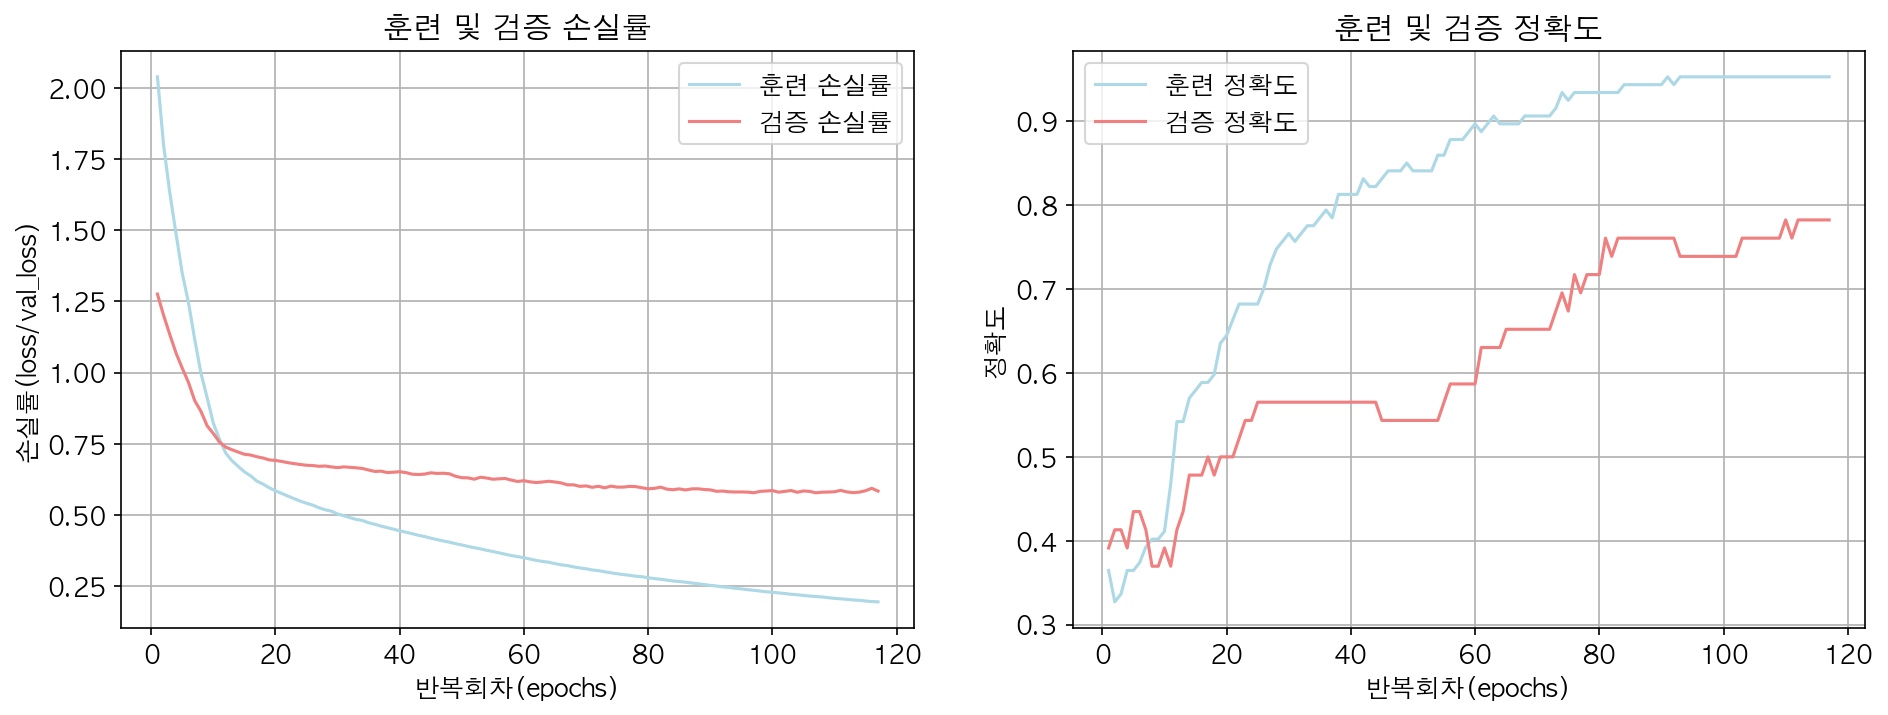

In [40]:
# 그래프 기본 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data= result_df,
            color='lightblue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data= result_df,
            color='lightcoral',
            label='검증 손실률',
            ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차(epochs)')
ax1.set_ylabel('손실률(loss/val_loss)')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 평균절대오차 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='lightblue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='lightcoral',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차(epochs)')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

- 모델 성능 평가

In [29]:
evaluate1 = my_model.evaluate(x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

4/4 [==============================] - 0s 2ms/step - loss: 0.1913 - acc: 0.9533
최종 훈련 손실률: 0.191346, 최종 훈련 정확도: 0.953271
2/2 [==============================] - 0s 3ms/step - loss: 0.5835 - acc: 0.7826
최종 검증 손실률: 0.583537, 최종 검증 정확도: 0.782609


### 8) 학습 결과 적용
- 예측 결과 산정

In [56]:
# 훈련 데이터에 대한 예측 결과 산정
train_predict = my_model.predict(x_train)
# 검증 데이터에 대한 예측 결과 산정
test_predict = my_model.predict(x_test)

4/4 [==============================] - 0s 803us/step


2/2 [==============================] - 0s 1ms/step


- 결과 데이터셋 구성: 
    - 훈련데이터와 검증데이터의 크기(행 수 -> 7대 3)가 다르기 때문에 이 둘을 데이터프레임으로 결합 못한다
    - -> 배열 크기가 다르다고 에러가 날 것
    - 그러므로 훈련데이터 셋과 검증데이터 셋을 따로 만들어야 된다

In [57]:
kdf = DataFrame({
    '결과값': y_train['Recur'].values,
    '예측값': np.round(train_predict.flatten()),
    'Recur_Rate(%)': np.round(train_predict.flatten() * 100, 1)
})
kdf

,결과값,예측값,Recur_Rate(%)
0,1,1.0,98.400002
1,0,0.0,7.300000
2,0,0.0,5.000000
3,0,0.0,1.800000
4,0,0.0,11.400000
...,...,...,...
102,1,1.0,91.199997
103,0,0.0,5.400000
104,1,0.0,31.799999
105,0,0.0,8.300000


- 혼돈행렬

In [49]:
cm = confusion_matrix(kdf['결과값'], kdf['예측값'])
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
cmdf1 = DataFrame([[tn, fn], [fp, tp]], 
                  index=['Actual(0)', 'Actual(1)'], 
                  columns=['Predicted(0)', 'Predicted(1)'])
cmdf1

46 1 4 56


,Predicted(0),Predicted(1)
Actual(0),46,4
Actual(1),1,56


In [50]:
cm2 = confusion_matrix(kdf['결과값'], kdf['예측값'])
cmdf2 = DataFrame(cm2, 
                  index=['실제(0)', '실제(1)'], 
                  columns=['예측(0)', '예측(1)'])
cmdf2

,예측(0),예측(1)
실제(0),46,1
실제(1),4,56


- 혼돈 행렬을 히트맵 그래프로 표현

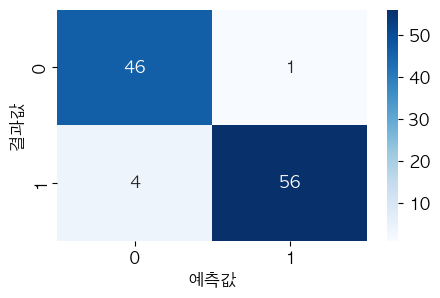

In [51]:
plt.figure(figsize=(5, 3))
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sb.heatmap(cm,
           annot = True,
           fmt = 'd',
           cmap = 'Blues')
plt.xticks([0.5,1.5], ['0', '1'])
plt.yticks([0.5,1.5], ['0', '1'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

- 평가지표

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

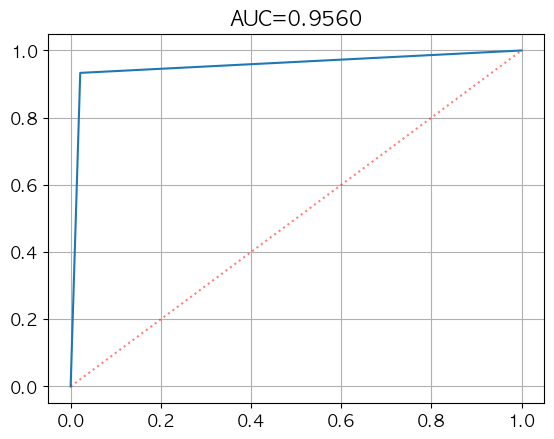

In [53]:
ras = roc_auc_score(kdf['결과값'], kdf['예측값'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(kdf['결과값'], kdf['예측값'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1],
            y=[0,1],
            color='red',
            linestyle=':',
            alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

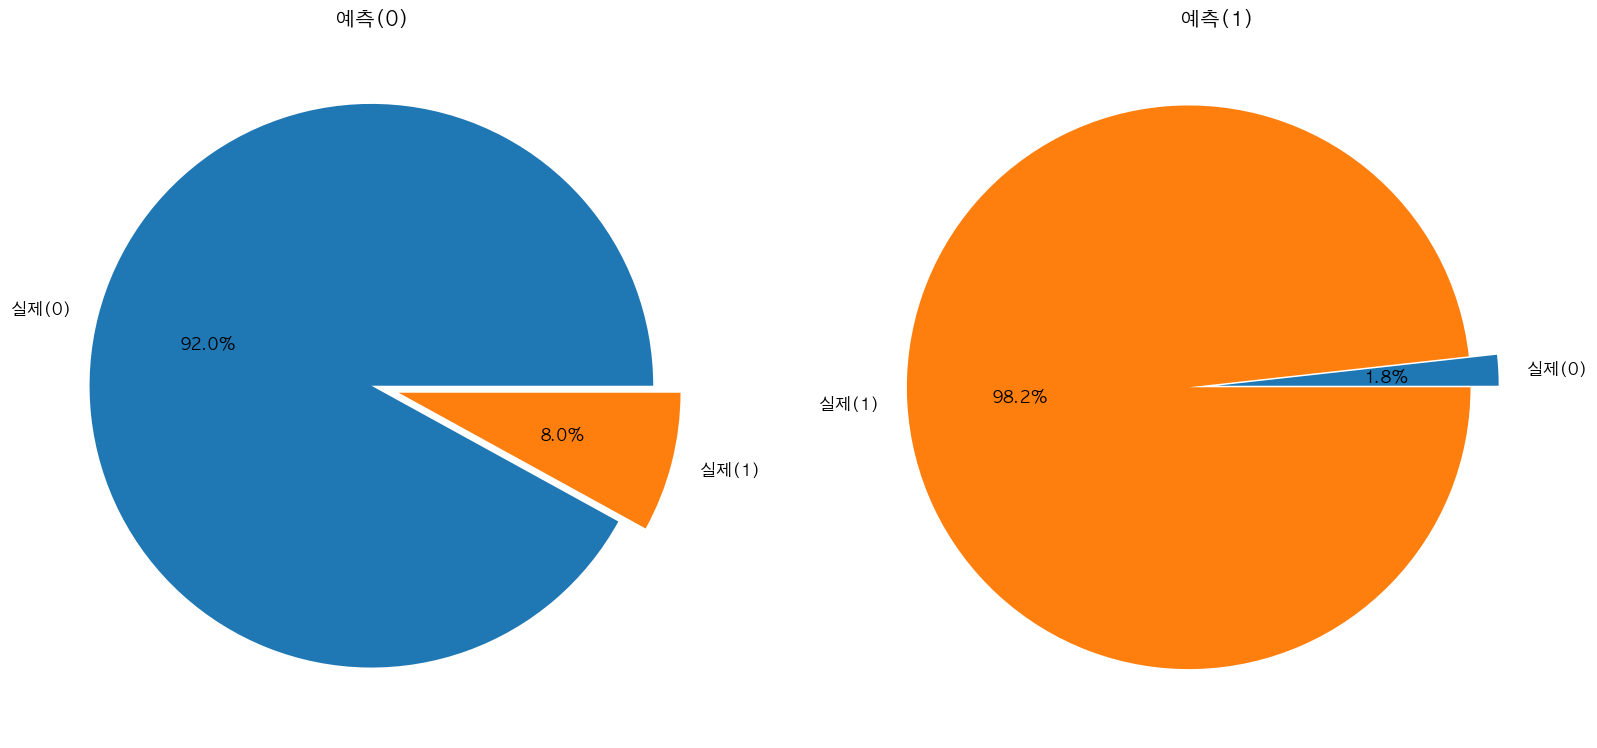

In [61]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

cmdf2['예측(0)'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax1)
ax1.set_title('예측(0)')
ax1.yaxis.set_visible(False) # y-label 제거

cmdf2['예측(1)'].plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax2)
ax2.set_title('예측(1)')
ax2.yaxis.set_visible(False) # y-label 제거

plt.show()
plt.close()